# Sections

Frameworks:

* PyTorch first pass
    * `Model` with `forward` method.
    * Manual training loop
* PyTorch second pass
    * `Model` with `forward` method.
    * `Trainer` class that takes in:
        * `Model`
        * `Optimizer`
        * `_Loss`

Models:

* Boston dataset (used for testing)
* MNIST Conv net
* LSTM layer

In [25]:
# imports
from typing import Tuple, List
from collections import deque

import torch
import torch.optim as optim
from torch.optim import Optimizer

import numpy as np
from torch import Tensor

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss

from lincoln.utils import permute_data, assert_dim

from lincoln.pytorch.model import PyTorchModel
from lincoln.pytorch.train import PyTorchTrainer
from lincoln.pytorch.preprocessor import ConvNetPreprocessor

torch.manual_seed(20190325);

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## `Trainer` class

# Boston dataset

In [27]:
from sklearn.datasets import load_boston

boston = load_boston()

data = boston.data
target = boston.target
features = boston.feature_names

from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)

y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

X_train, X_test, y_train, y_test = Tensor(X_train), Tensor(X_test), Tensor(y_train), Tensor(y_test)

### Defining Boston model

In [28]:
class PyTorchLayer(nn.Module):

    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        raise NotImplementedError()

In [29]:
class DenseLayer(PyTorchLayer):
    def __init__(self,
                 input_size: int,
                 neurons: int,
                 activation: nn.Module = None) -> None:
        super().__init__()
        self.linear = nn.Linear(input_size, neurons)
        self.activation = activation


    def forward(self, x: Tensor) -> Tensor:

        x = self.linear(x) # does weight multiplication + bias
        if self.activation:
            x = self.activation(x)
            
        return x

In [30]:
class BostonModel(PyTorchModel):

    def __init__(self,
                 hidden_size: int = 13):
        super().__init__()
        self.dense1 = DenseLayer(13, hidden_size, activation=nn.Tanh())
        self.dense2 = DenseLayer(hidden_size, 1)

    def forward(self, x: Tensor) -> Tensor:
        
        assert_dim(x, 2)
        
        assert x.shape[1] == 13

        x = self.dense1(x)
        return self.dense2(x)

In [31]:
# model, optimizer, loss
pytorch_boston_model = BostonModel(hidden_size=13)
optimizer = optim.SGD(pytorch_boston_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [32]:
trainer = PyTorchTrainer(pytorch_boston_model, optimizer, criterion)

trainer.fit(X_train, y_train, X_test, y_test,
            epochs=300,
            eval_every=10)

0 tensor(552.8856)
10 tensor(76.9690)
20 tensor(46.1771)
30 tensor(39.2791)
40 tensor(33.5310)
50 tensor(29.2469)
60 tensor(25.4051)
70 tensor(22.8295)
80 tensor(20.7839)
90 tensor(19.1065)
100 tensor(20.2159)
110 tensor(17.1996)
120 tensor(15.6069)
130 tensor(17.7104)
140 tensor(14.1601)
150 tensor(14.4325)
160 tensor(12.9108)
170 tensor(12.5565)
180 tensor(12.7575)
190 tensor(12.1290)
200 tensor(12.6223)
210 tensor(12.0121)
220 tensor(12.2005)
230 tensor(13.8037)
240 tensor(11.8467)
250 tensor(11.7453)
260 tensor(11.6440)
270 tensor(13.1057)
280 tensor(12.6793)
290 tensor(11.6068)


In [33]:
torch.mean(torch.pow(pytorch_boston_model(X_test) - y_test, 2)).item()

11.557090759277344

In [34]:
test_pred = pytorch_boston_model(X_test).view(-1)
test_actual = y_test

In [35]:
test_pred = test_pred.detach().numpy()
test_actual = test_actual.detach().numpy()

## Boston - EDA

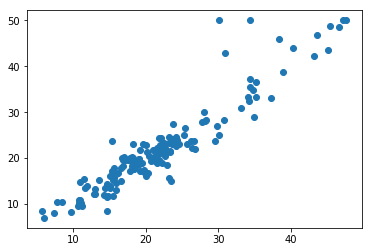

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(test_pred, test_actual)

### MNIST data

In [13]:
from torchvision.datasets import MNIST
mnist_trainset = MNIST(root="../exploratory/data/", train=True, download=True, transform=None)
mnist_testset = MNIST(root="../exploratory/data/", train=False, download=True, transform=None)

In [14]:
mnist_train = mnist_trainset.train_data.type(torch.float32).unsqueeze(3) / 255.0
mnist_test = mnist_testset.test_data.type(torch.float32).unsqueeze(3) / 255.0

In [15]:
class ConvLayer(PyTorchLayer):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 filter_size: int,
                 activation: nn.Module = None,
                 flatten: bool = False) -> None:
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, filter_size, 
                              padding=filter_size // 2)
        self.activation = activation
        self.flatten = flatten

    def forward(self, x: Tensor) -> Tensor:

        x = self.conv(x)
        if self.activation:
            x = self.activation(x)
        if self.flatten:
            x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
            
        return x

In [16]:
class MNIST_ConvNet(PyTorchModel):
    def __init__(self):
        super().__init__()
        self.conv1 = ConvLayer(1, 16, 5, activation=nn.Tanh())
        self.conv2 = ConvLayer(16, 8, 5, activation=nn.Tanh(), flatten=True)
        self.dense1 = DenseLayer(28 * 28 * 8, 32, activation=nn.Tanh())
        self.dense2 = DenseLayer(32, 10)

    def forward(self, x: Tensor) -> Tensor:
        assert_dim(x, 4)
            
        x = self.conv1(x)
        x = self.conv2(x)

        x = self.dense1(x)
        x = self.dense2(x)
        return x

In [17]:
model = MNIST_ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
preprocessor = ConvNetPreprocessor()

In [20]:
X_train, X_test = mnist_train.permute(0, 3, 1, 2), mnist_test.permute(0, 3, 1, 2)

In [21]:
trainer = PyTorchTrainer(model, optimizer, criterion)

trainer.fit(X_train, mnist_trainset.train_labels, 
            X_test, mnist_testset.test_labels,
            epochs=5,
            eval_every=1)

0 tensor(0.0829)
1 tensor(0.0683)
2 tensor(0.0618)
3 tensor(0.0560)
4 tensor(0.0545)


In [22]:
out = model(X_test)

In [23]:
(torch.max(out, dim=1)[1] == mnist_testset.test_labels).sum()

tensor(9845)

~98% accuracy

## LSTM

Working backwards:

* Want a character level model - predict next char.

How to do it?

Pass in sequences. 

### New classes: `NextCharacterModel` and `LSTMTrainer`

* 5 = seq_len
* 3 = batch
* 10 = input_size
* 20 = hidden_size

* h0 = `(num_layers, batch_size, hidden_size)` = (2, 3, 20)

nn.LSTM(input_size, hidden_size, num_layers)

In [58]:
class LSTMLayer(PyTorchLayer):
    def __init__(self,
                 sequence_length: int,
                 input_size: int,
                 hidden_size: int,
                 output_size: int) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.h_init = torch.zeros((1, hidden_size))
        self.c_init = torch.zeros((1, hidden_size))
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = DenseLayer(hidden_size, output_size)

        
    def _transform_hidden_batch(self, hidden: Tensor,
                                batch_size: int,
                                before_layer: bool) -> Tensor:
        
        if before_layer:
            return (hidden
                    .repeat(batch_size, 1)
                    .view(batch_size, 1, self.hidden_size)
                    .permute(1,0,2))
        else:
            return (hidden
                    .permute(1,0,2)
                    .mean(dim=0))         
    

    def forward(self, x: Tensor) -> Tensor:
        
        batch_size = x.shape[0]

        h_layer = self._transform_hidden_batch(self.h_init, batch_size, before_layer=True)
        c_layer = self._transform_hidden_batch(self.c_init, batch_size, before_layer=True)
        
        x, (h_out, c_out) = self.lstm(x, (h_layer, c_layer))
        
        self.h_init, self.c_init = (
            self._transform_hidden_batch(h_out, batch_size, before_layer=False).detach(),
            self._transform_hidden_batch(c_out, batch_size, before_layer=False).detach()
        )

        x = self.fc(x)
            
        return x

In [65]:
lay = LSTMLayer(sequence_length=25,
          input_size=62,
          hidden_size=100,
          output_size=128)

x = torch.randn(32, 25, 62)

lay(x).shape

torch.Size([32, 25, 128])

In [66]:
class NextCharacterModel(PyTorchModel):
    def __init__(self,
                 vocab_size: int,
                 hidden_size: int = 256,
                 sequence_length: int = 25):
        super().__init__()
        self.vocab_size = vocab_size
        self.sequence_length = sequence_length
        
        # In this model, we have only one layer, with the same output size as input_size
        self.lstm = LSTMLayer(self.sequence_length, self.vocab_size, hidden_size, self.vocab_size)

    def forward(self,
                inputs: Tensor):
        assert_dim(inputs, 3) # batch_size, sequence_length, vocab_size

        out = self.lstm(inputs)       
        
        return out.permute(0, 2, 1)

In [71]:
class LSTMTrainer(PyTorchTrainer):
    def __init__(self,
                 model: NextCharacterModel,
                 optim: Optimizer,
                 criterion: _Loss):
        super().__init__(model, optim, criterion)
        self.vocab_size = self.model.vocab_size
        self.max_len = self.model.sequence_length
        
    def fit(self,
            data: str,
            epochs: int=10,
            eval_every: int=1,
            batch_size: int=32,
            seed: int = 121718)-> None:
        
        self.data = data
        self.train_data, self.test_data = self._train_test_split_text()
        self.chars = list(set(self.data))
        self.char_to_idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(self.chars)}

        torch.manual_seed(seed)

        losses = deque(maxlen=50)
        
        for e in range(epochs):

            batch_generator = self.generate_batches_next_char(batch_size)

            for ii, (X_batch, y_batch) in enumerate(batch_generator):

                self.optim.zero_grad()                
                outputs = self.model(X_batch)

                loss = self.loss(outputs, y_batch)
                losses.append(loss.item())

                loss.backward()
                print(loss.item())
                
                self.optim.step()    

            if (e+1) % eval_every == 0:

                X_test, y_test = self.generate_test_data()
            
                test_preds = self.net.forward(X_test)
                loss = self.net.loss.forward(test_preds, y_test)
                print(f"Validation loss after {e+1} epochs is {loss:.3f}")

    def _train_test_split_text(self, pct=0.8) -> Tuple[str]:

        n = len(self.data)
        return self.data[:int(n * pct)], self.data[int(n * pct):]

    def generate_batches_next_char(self,
                                   batch_size: int) -> Tuple[Tensor]:
        N = len(self.train_data)
        # add batch size
        for ii in range(0, N, batch_size):

            features_tensors = []
            target_indices = []

            for char in range(batch_size):

                features_str, target_str =\
                 self.train_data[ii+char:ii+char+self.max_len],\
                 self.train_data[ii+char+1:ii+char+self.max_len+1]

                features_array = self._string_to_one_hot_array(features_str)
                target_indices_seq = [self.char_to_idx[char] for char in target_str]

                features_tensors.append(features_array)
                target_indices.append(target_indices_seq)
#             import pdb; pdb.set_trace()
            yield torch.stack(features_tensors), torch.LongTensor(target_indices)

    def _string_to_one_hot_array(self, input_string: str) -> Tuple[Tensor]:

        ind = [self.char_to_idx[ch] for ch in input_string]

        array = self._one_hot_text_data(ind)

        return array

    def _one_hot_text_data(self,
                           sequence: List):

        sequence_length = len(sequence)
        batch = torch.zeros(sequence_length, self.vocab_size)
        for i in range(sequence_length):
            batch[i, sequence[i]] = 1.0

        return Tensor(batch)

    def generate_test_data(self) -> Tuple[Tensor]:

        features_str, target_str = self.test_data[:-1], self.test_data[1:]

        X_tensors = []
        y_tensors = []

        N = len(self.test_data)

        for start in range(0, N, self.max_len):

            features_str, target_str =\
             self.test_data[start:start+self.max_len],\
             self.test_data[start+1:start+self.max_len+1]

            features_array, target_array =\
                self._string_to_one_hot_array(features_str),\
                self._string_to_one_hot_array(target_str)

            X_tensors.append(features_array)
            y_tensors.append(target_array)

        return torch.stack(X_tensors), torch.stack(y_tensors)


In [72]:
data = open('data/input.txt', 'r').read()
vocab_size = len(set(data))
model = NextCharacterModel(vocab_size, hidden_size=vocab_size, sequence_length=50)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,
                             weight_decay=1e-5)

In [73]:
lstm_trainer = LSTMTrainer(model, optimizer, criterion)

In [74]:
lstm_trainer.fit(data)

4.127601146697998
4.111598014831543
4.105199337005615
4.106496810913086
4.0934858322143555
4.077452182769775
4.0833940505981445
4.075546741485596
4.0595383644104
4.075404167175293
4.078780651092529
4.068609714508057
4.054238319396973
4.014968395233154
4.008720874786377
4.0064191818237305
3.993131637573242
3.9759786128997803
3.959608554840088
3.9405219554901123
3.9246468544006348
3.938478469848633
3.869570732116699
3.8072006702423096
3.747617244720459
3.732602119445801
3.6944665908813477
3.6197762489318848
3.566596269607544
3.4648680686950684
3.3709990978240967
3.5467846393585205
3.693753242492676
3.2585761547088623
3.214423418045044
3.1433823108673096
3.181027412414551
3.2272729873657227
3.169543981552124
3.0808281898498535
3.2792317867279053
3.2352590560913086
3.123706102371216
3.119932174682617
3.0426392555236816
2.914970636367798
2.8726184368133545
3.117824077606201
3.114644765853882
3.061026096343994
3.00258207321167
3.2040374279022217
4.063312530517578
3.4589874744415283
3.0977673

KeyboardInterrupt: 

TODO:

* Write code to generate next character from this.
* Write early stopping code.

## Section name: Grokking Advanced Architectures

## Transformer

Same data source as LSTM: 

* TODO: Draw computational graph
* TODO: Describe input and output data

## Neural Turing Machine